In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dsp.agc import AGC
from dsp.am import AMDemodulator
from dsp.fir import WSFilter
from dsp.plot import welch
from utils import plot_some

In [2]:
# Carrier parameters.
A = 5
f = 57000
fs = 240000
phi = 0.5 * np.pi

# Message signal parameters.
A_m = 1
f_m = 2375
f_ms = 240000
phi_m = 0

n_samples = 10 ** 5
msg_samples = np.array([A_m * np.cos(2 * np.pi * f_m / f_ms * n + phi_m) for n in range(n_samples)])
carrier_samples = np.array([A * np.cos(2 * np.pi * f / fs * n + phi) for n in range(n_samples)])
samples = np.array([(1 + m / A) * c for c, m in zip(carrier_samples, msg_samples)])

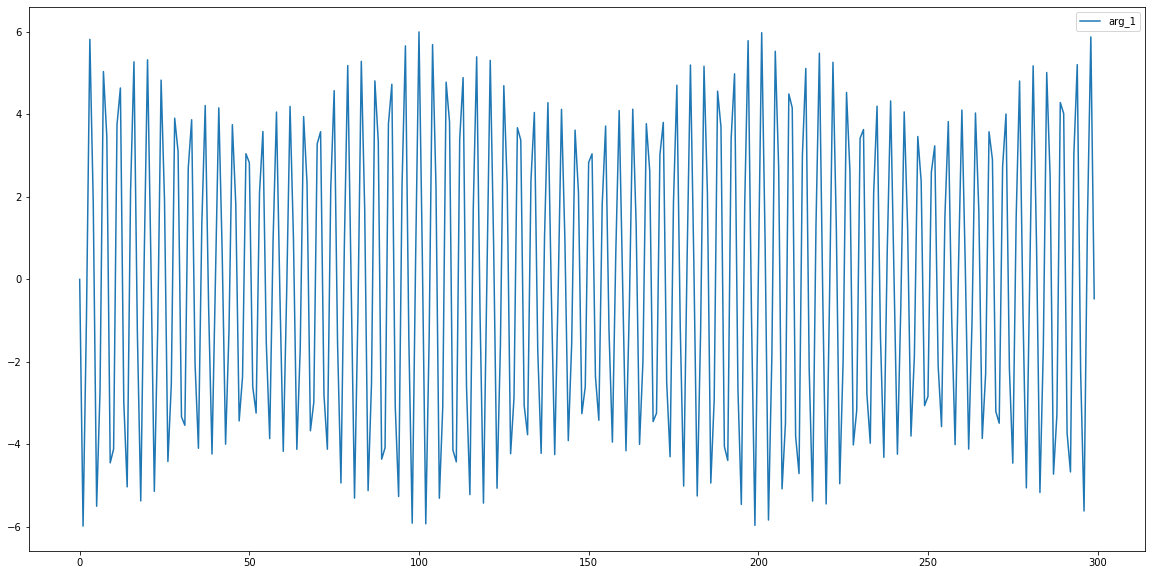

In [3]:
plot_some([samples], 0, 300)

In [4]:
am_demod = AMDemodulator(2 * f_m, f_ms, 1, agc=False)
hp = WSFilter(257, 1, 0.05 * f_m / f_ms, lowpass=False)
demod = am_demod.run(samples, carrier_samples / A)
demod = hp.real_run(demod)

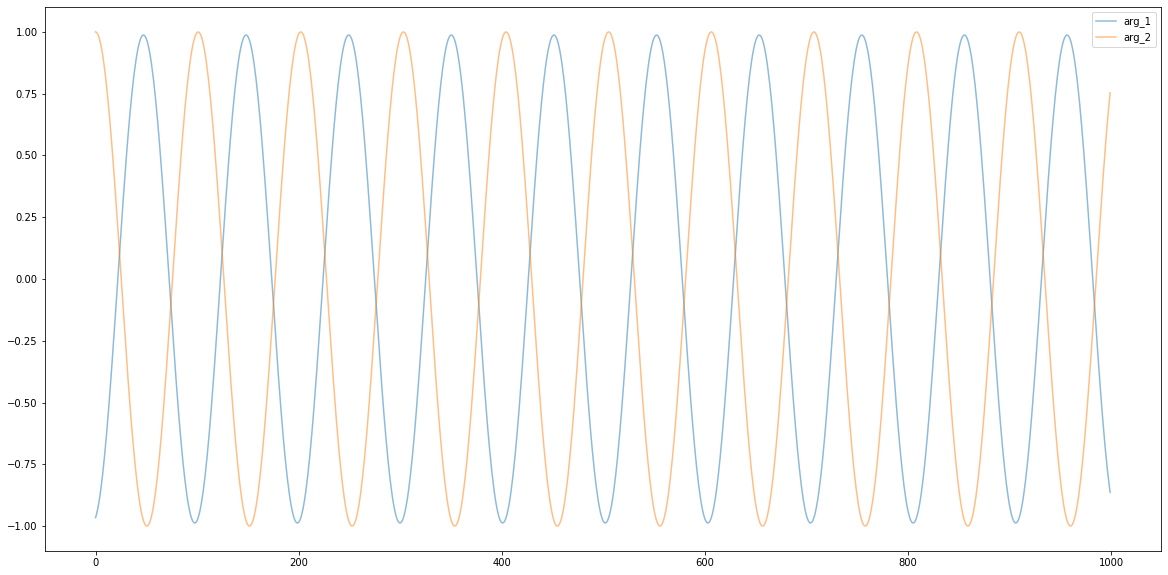

In [5]:
plot_some([demod, msg_samples], 0, 1000)

In [6]:
# Noisy carrier.
sigma = 0.05
noise_carrier_samples = np.array([(1 + sigma * np.random.randn()) * c for c in carrier_samples])

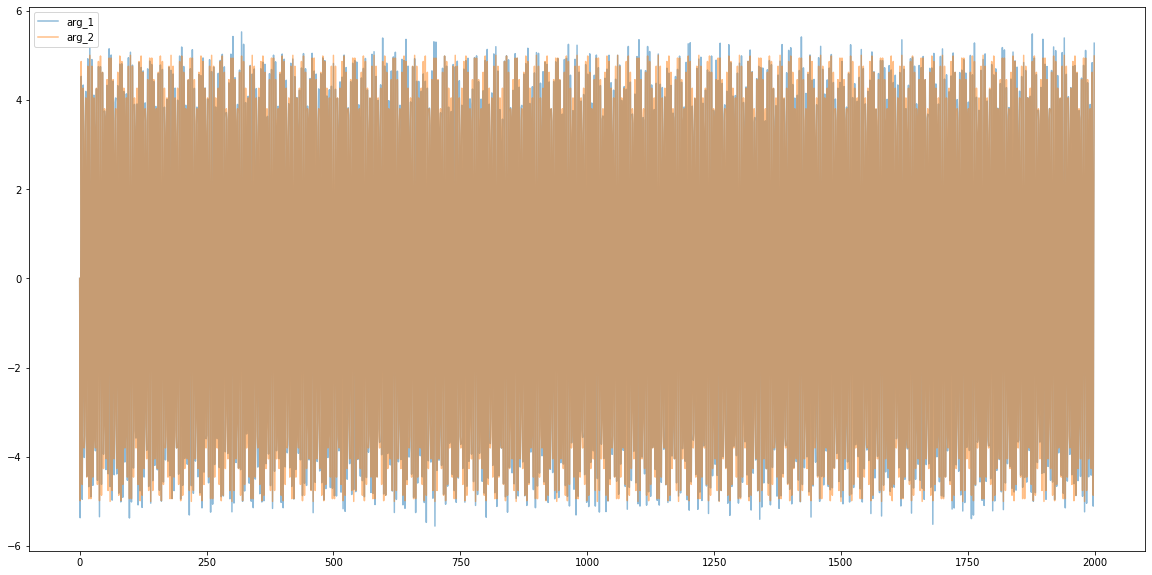

In [7]:
plot_some([noise_carrier_samples, carrier_samples], 0, 2000)

In [8]:
gain = 0.08
alpha = 0.3
agc = AGC(gain, alpha)
agc_carrier_samples = agc.run(noise_carrier_samples)

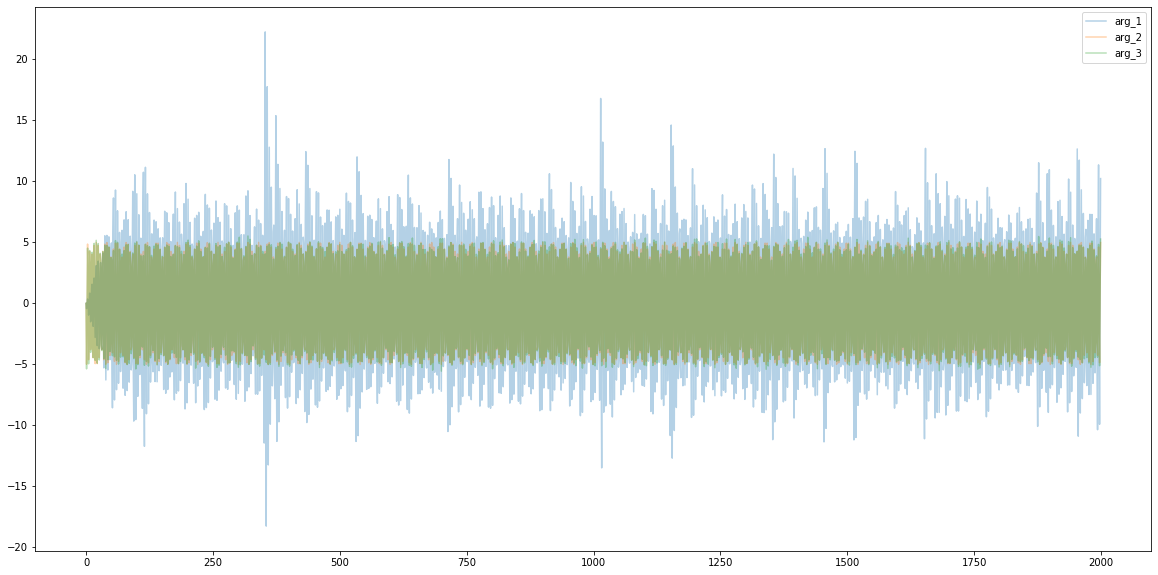

In [9]:
plot_some([agc_carrier_samples, carrier_samples, noise_carrier_samples], 0, 2000)

### Now try on real pilot signal.

In [10]:
pilot = np.load('./data/pilot_18900_19100.npy')

In [11]:
gain = 0.08
alpha2 = 0.11
agc2 = AGC(gain, alpha2)
agc_pilot = agc2.run(pilot)

/home/jlanecki/miniconda3/envs/radio/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/jlanecki/miniconda3/envs/radio/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


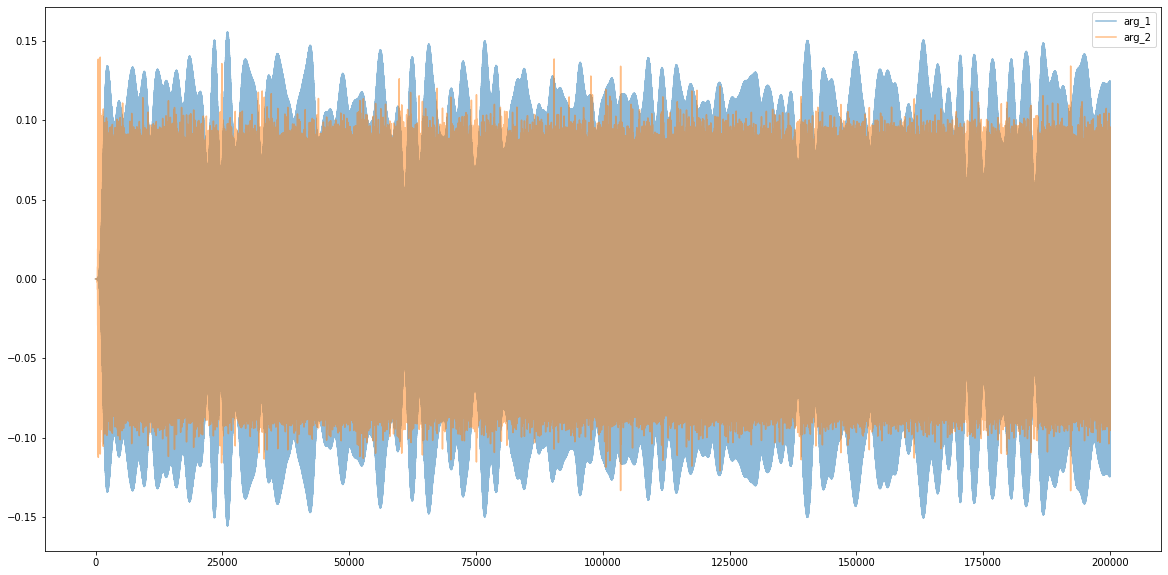

In [12]:
plot_some([pilot, 0.01 * agc_pilot], 0, 200000)

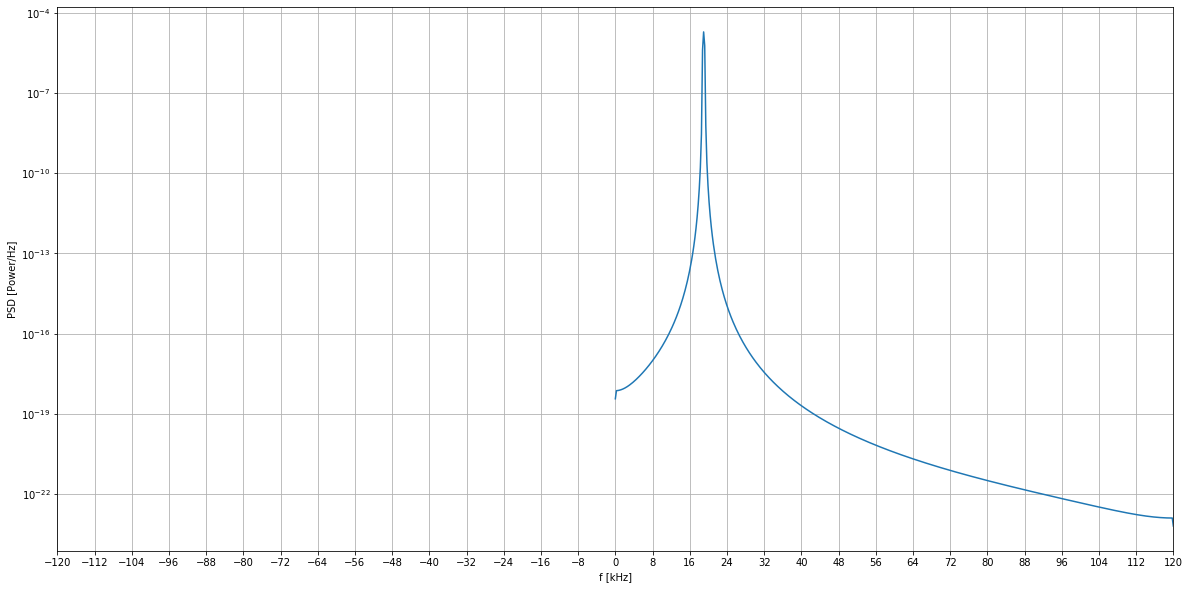

In [13]:
welch(pilot, 240000)

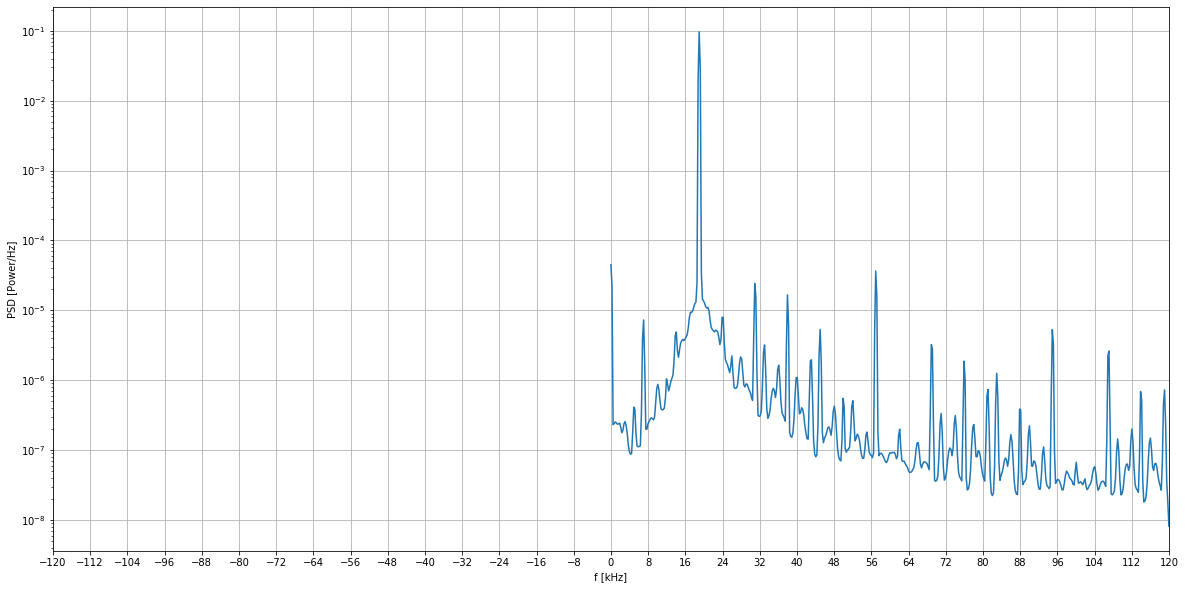

In [14]:
welch(agc_pilot, 240000)

In [15]:
from dsp.fir import WSFilter
lp = WSFilter(257, 1, 24000/240000)
hp = WSFilter(257, 1, 18000/240000, lowpass=False)
agc_pilot_lp = lp.real_run(agc_pilot)
agc_pilot_filtered = hp.real_run(agc_pilot_lp)

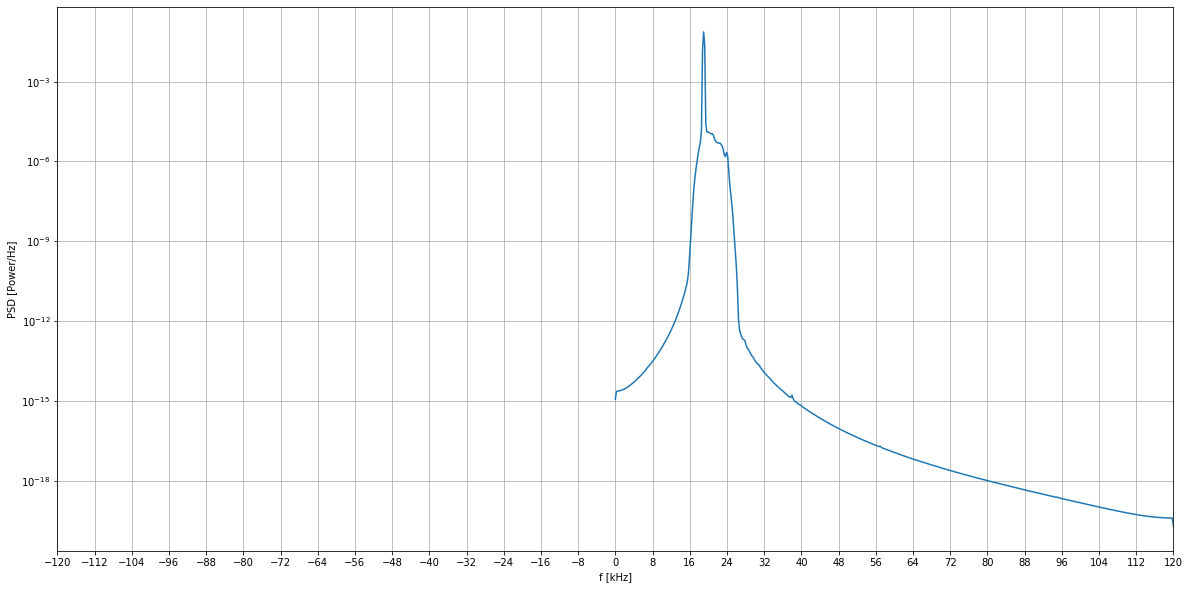

In [16]:
welch(agc_pilot_filtered, 240000)

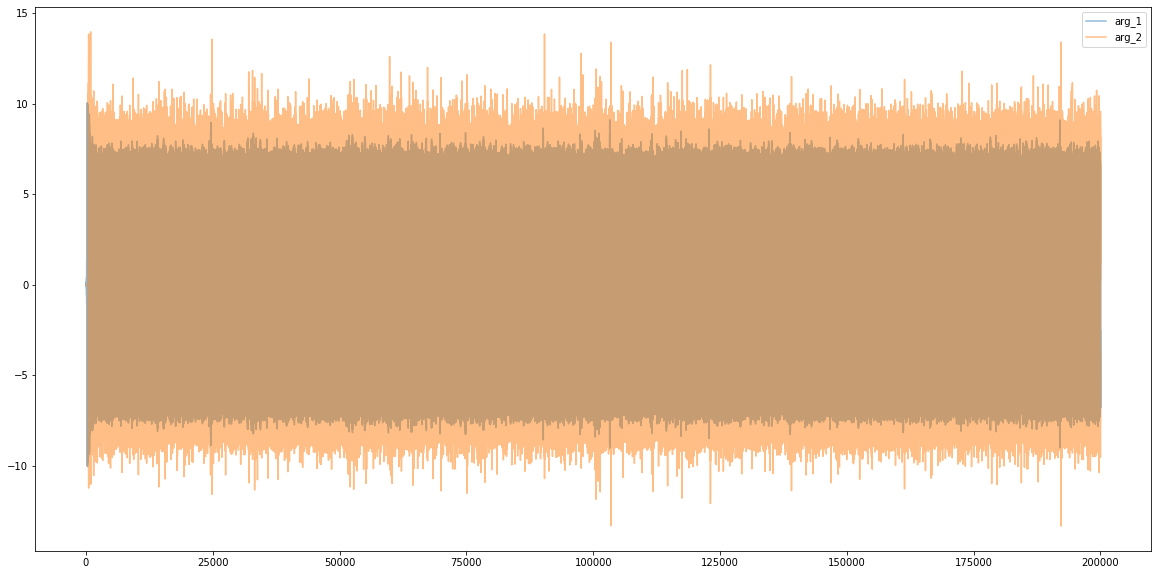

In [17]:
plot_some([agc_pilot_filtered, agc_pilot], 0, 200000)

There is an issue with all filtering though - it alters the phase of the signal, which is what we need for AM demodulation. But it seems that some filtering is necessary if we want to use the pilot tone at all. 

Also, (I think) it can be shown that if the phase difference between the original pilot (and hence the 57 kHz carrier tone) and obtained filtered pilot signal is constant, then obtained output signal differs from the original only by some factor - which should not matter. 